## 0.1 - Включение рейтинга 26 и заражение датой восстановления.

**Цель:** Учесть 26 рейтинг как дефолт и обогатить данные о дефолтах, проделать заражение по дате восстановления и проставить единую дату дефолта по компании и ее дате восстановления. 

**Prerequisites:**
Данные о технических дефолтах;Данные о рейтингах компании.

**Результат:** 
Очищенный и предобработанный датасет с полной историей дефолтов, готовый для использования в последующих этапах моделирования.

--------
В данном ноутбуке происходит обогащение данных о технических дефолтах, выгруженных через SQL-скрипт, клиентами, получившими рейтинг 26: данный рейтинг является индикатором дефолта.Ключевая особенность обработки — "заражение" датой восстановления: при наличии нескольких записей о дефолтах одного клиента, дата восстановления распространяется от будущих записей к предыдущим через механизм backward fill. Это позволяет связать разрозненные события в единую историю дефолтов клиента.
Для клиентов без даты восстановления проставляется условная будущая дата (2199-01-01) для унификации дальнейшей обработки. Дата восстановления - дата, когда клиент больше не находится в дефолте.Поскольку клиенты могут входить в дефолт многократно, выгрузка сохраняет все такие эпизоды. На финальном этапе данные группируются по паре (client_id, recovery_date), где для каждой группы определяется минимальная дата дефолта. Это позволяет корректно выделить начало каждого периода дефолта в истории клиента.

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import yaml

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', None)

### 0.1.1 - Пути

In [3]:
with open('../CONFIGS.yaml', 'r') as file:
    CONFIG = yaml.safe_load(file)

PATHS = CONFIG['data_paths']

In [4]:
filepath = {
      'raw_ratings' : PATHS['ratings']['raw']
    , 'raw_defaults': PATHS['risk']['defaults_raw']
    , 'preprocessed_defaults' : PATHS['risk']['defaults_preprocessed']
    , 'preprocessed_ratings_full' : PATHS['ratings']['preprocessed_full']
    , 'preprocessed_ratings_compact' : PATHS['ratings']['preprocessed_compact']
}

### 0.1.2 - Чтение Ratings

In [5]:
df_ratings = pd.read_excel(filepath['raw_ratings'])

In [6]:
df_ratings.columns = df_ratings.columns.str.lower()

df_ratings = df_ratings.reset_index() 
df_ratings.rename({    'index'     : 'rating_id'
                    , 'itog_rate' : 'rating_final'
                    , 'pred_rate' : 'rating_preliminary'
                    # , 'date_utv'  : 'default_date'
                    , 'date_utv'  : 'rating_assignment_date'
                    , 'cust_id'   : 'client_id'
                }
                , axis=1
                , inplace=True)

df_ratings['bin'].replace(' ', None, inplace=True)
df_ratings.drop(['bin_number'], inplace=True, axis=1)

df_ratings['rating_assignment_date'] = pd.to_datetime(df_ratings['rating_assignment_date']).dt.date
df_ratings['client_id'] = df_ratings['client_id'].astype('Int64')

In [7]:
df_ratings.dropna(subset=['client_id'], axis=0, inplace=True)

In [8]:
df_ratings.to_csv(filepath['preprocessed_ratings_full'], encoding='utf-8', sep='|')

In [9]:
rating_cols = ['bin', 'client_id', 'rating_id', 'rating_preliminary', 'rating_final', 'rating_assignment_date']
df_ratings = df_ratings[rating_cols]

df_ratings.head()

,bin,client_id,rating_id,rating_preliminary,rating_final,rating_assignment_date
0,040940002520,781908,0,14,14.0,2018-08-08
1,090240019261,749596,1,13,13.0,2018-08-08
3,911040000150,711998,3,13,13.0,2018-02-14
4,890619300019,2662074,4,13,13.0,2018-02-14
5,991240000043,748902,5,14,14.0,2018-01-31


In [10]:
df_ratings.to_csv(filepath['preprocessed_ratings_compact'], encoding='cp1251', sep='|')

### 0.1.3 0 Выделение компаний с итоговым рейтингом 26

In [11]:
df_ratings_26 = df_ratings\
                    .query('rating_final == 26')\
                    [['bin', 'client_id','rating_preliminary', 'rating_final', 'rating_assignment_date']].copy()

df_ratings_26['recovery_date'] = None
df_ratings_26['default_date'] = df_ratings_26['rating_assignment_date']

### 0.1.4 - Defaults

In [13]:
df_defaults_original = pd.read_csv(filepath['raw_defaults'], encoding='cp1251', sep='|')
# df_defaults_original = pd.read_csv(PATHS['defaults_without_msfo'], encoding='cp1251', sep='|')
df_defaults_original.columns = df_defaults_original.columns.str.lower()

df_defaults_original.rename({   'cust_id' : 'client_id'
                    , 'iinbin'  : 'bin'
                    , 'recovery_date_last' : 'recovery_date'
                  }
                  , axis=1
                  , inplace=True
)

df_defaults_original['default_date']  = pd.to_datetime(df_defaults_original['default_date'], format='%Y-%m-%d').dt.date
df_defaults_original['recovery_date'] = pd.to_datetime(df_defaults_original['recovery_date'], format='%Y-%m-%d').dt.date

In [14]:
df_defaults_original.bin.nunique(), df_defaults_original.client_id.nunique()

(209, 209)

#### Обогощение дефолтов рейтингом 26

In [15]:
cols_concat = ['bin', 'client_id', 'default_date', 'recovery_date']

df1 = df_defaults_original[cols_concat].copy()
df2 = df_ratings_26[cols_concat].copy()

df_defaults_enriched = pd.concat([df1, df2], ignore_index=True)

In [16]:
def process_client(client_records):
    # Sort within client_records
    client_records = client_records.sort_values(by=['default_date', 'recovery_date'])
    
    # Drop duplicates
    client_records = client_records.drop_duplicates(subset=['default_date'], keep='first')
    
    # Backward fill
    client_records = client_records.bfill()
    
    # Handle recovery_date
    client_records['recovery_date'] = client_records['recovery_date'].fillna('2199-01-01')
    client_records['recovery_date'] = pd.to_datetime(client_records['recovery_date']).dt.date
    
    # client_records by recovery_date and get min default_date
    result = client_records.groupby('recovery_date', as_index=False).agg({'default_date': 'min'})
    result['client_id'] = client_records['client_id'].iloc[0]
    
    return result[['client_id', 'default_date', 'recovery_date']]

# Apply to all clients at once
df_default_episodes = df_defaults_enriched.groupby('client_id', group_keys=False).apply(process_client)

In [17]:
df_default_episodes['days_in_default'] = df_default_episodes['recovery_date'] - df_default_episodes['default_date']
df_default_episodes['days_in_default'] = df_default_episodes['days_in_default'] / np.timedelta64(1, 'D')

In [18]:
cols = ['client_id', 'default_date']

df_default_episodes.groupby(cols, as_index = False) \
        .agg({'recovery_date': 'count'}) \
        .rename(columns = {'recovery_date': 'count'}) \
        .sort_values(by = ['count'], ascending = False)

,client_id,default_date,count
296,6704999,2025-03-01,1
0,197080,2023-05-02,1
1,197228,2018-02-02,1
2,678519,2021-06-10,1
3,679870,2018-06-14,1
...,...,...,...
13,689330,2021-07-08,1
12,689330,2021-02-04,1
11,689330,2020-04-01,1
10,688914,2022-04-01,1


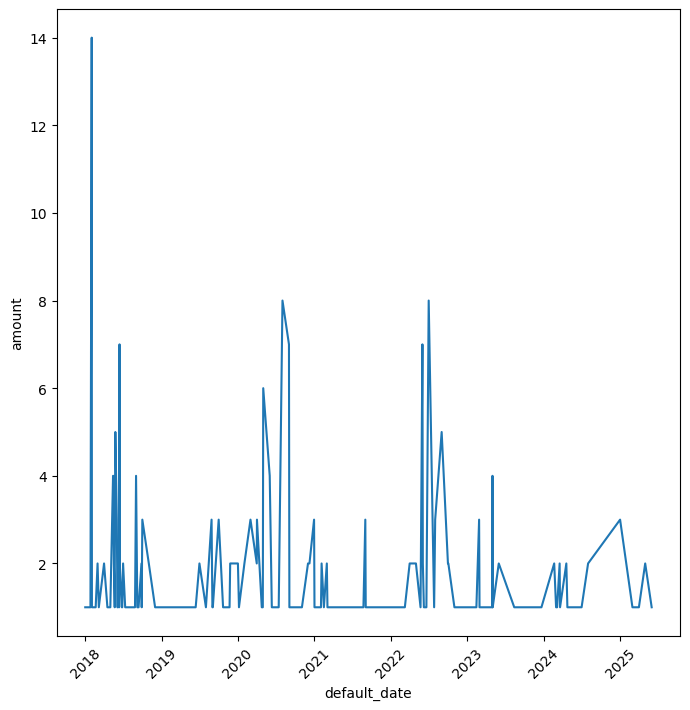

In [19]:
agg_data = df_default_episodes \
            .groupby(['default_date']) \
            .agg({'client_id': 'count'}) \
            .rename(columns={'client_id': 'amount'})

plt.figure(figsize = (7,7))
ax = sns.lineplot(data = agg_data['amount'], dashes = False)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [20]:
df_default_episodes.groupby('client_id')['default_date'].nunique().sort_values(ascending=False)

client_id
1917316    5
748720     4
749712     4
751465     4
689330     4
          ..
6263276    1
6529855    1
6601130    1
6610199    1
6704999    1
Name: default_date, Length: 241, dtype: int64

Конкретный пример

In [21]:
example = 749712

In [22]:
df_defaults_enriched\
    .query('client_id == @example').sort_values(['default_date', 'recovery_date'])

,bin,client_id,default_date,recovery_date
6324,101040016455,749712,2018-07-11,None
737,101040016455,749712,2018-09-01,NaT
745,101040016455,749712,2018-09-01,NaT
746,101040016455,749712,2018-09-01,NaT
747,101040016455,749712,2018-09-01,NaT
6384,101040016455,749712,2018-09-07,None
6390,101040016455,749712,2018-09-28,None
806,101040016455,749712,2018-10-01,NaT
807,101040016455,749712,2018-10-01,NaT
808,101040016455,749712,2018-10-01,NaT


In [23]:
df_default_episodes\
    .query('client_id == @example').sort_values(['client_id', 'default_date', 'recovery_date'])

,client_id,default_date,recovery_date,days_in_default
1,749712,2018-07-11,2020-10-01,813.0
0,749712,2020-01-01,2020-07-01,182.0
2,749712,2020-03-01,2021-10-01,579.0
3,749712,2021-03-01,2199-01-01,64954.0


### 0.1.5 - Сохранение данных

In [24]:
df_default_episodes\
    .drop(columns=['days_in_default'])\
    .to_csv(  filepath['preprocessed_defaults']
            , sep='|'
            , encoding='cp1251'
            , index=False)